In [4]:
#Ship detection data visualization and analysis
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage.data import imread
from pathlib import Path
from skimage.measure import label, regionprops
from skimage.morphology import label

In [5]:
train = pd.read_csv('../input/train_ship_segmentations_v2.csv')
train.head()


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


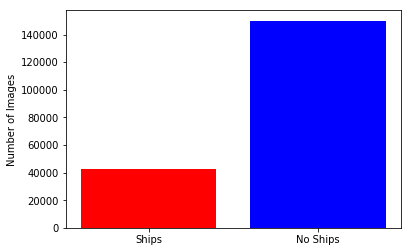

In [6]:
ships = train[~train.EncodedPixels.isna()].ImageId.unique()
noships = train[train.EncodedPixels.isna()].ImageId.unique()
plt.bar(['Ships', 'No Ships'], [len(ships), len(noships)], color=["red","blue"]);
plt.ylabel('Number of Images');

> #### As you can see, the EncodedPixels are the ship location in the imgs. <br>For example, total pixels are 768*768 = 589824, in pic 2, 264661  17 means, from 264661 pixel to 264678 pixel are ship. This is for training data only. What we need to feed back is something like this.<br>Also, Nan means no ship in the image.

>#### Look at images with ships

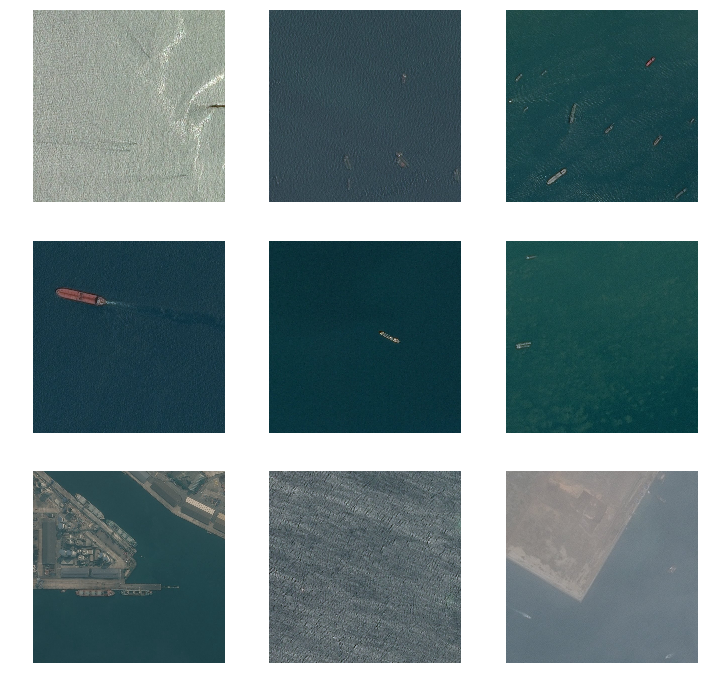

In [7]:
train_sample = train[~train.EncodedPixels.isna()].sample(9)
#randomly choose 9 pics from train images with ships
fig, axes = plt.subplots(3, 3, figsize=(12,12))
for i, image_id in enumerate(train_sample.ImageId):
    col = i % 3
    row = i // 3
    img = imread(f'../input/train_v2/{image_id}')
    axes[row, col].axis('off')
    axes[row, col].imshow(img)

>#### Look at images without ships

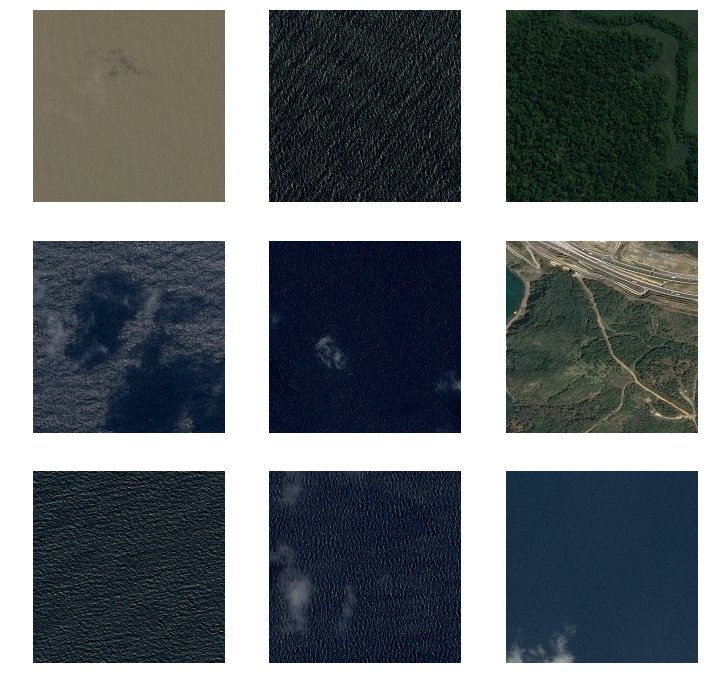

In [8]:
train_sample = train[train.EncodedPixels.isna()].sample(9)
#randomly choose 9 pics from train images without ships
fig, axes = plt.subplots(3, 3, figsize=(12,12))
for i, image_id in enumerate(train_sample.ImageId):
    col = i % 3
    row = i // 3
    img = imread(f'../input/train_v2/{image_id}')
    axes[row, col].axis('off')
    axes[row, col].imshow(img)

>#### Mask the training data with segmentations infomation.<br>1 - ship    0 - no ship

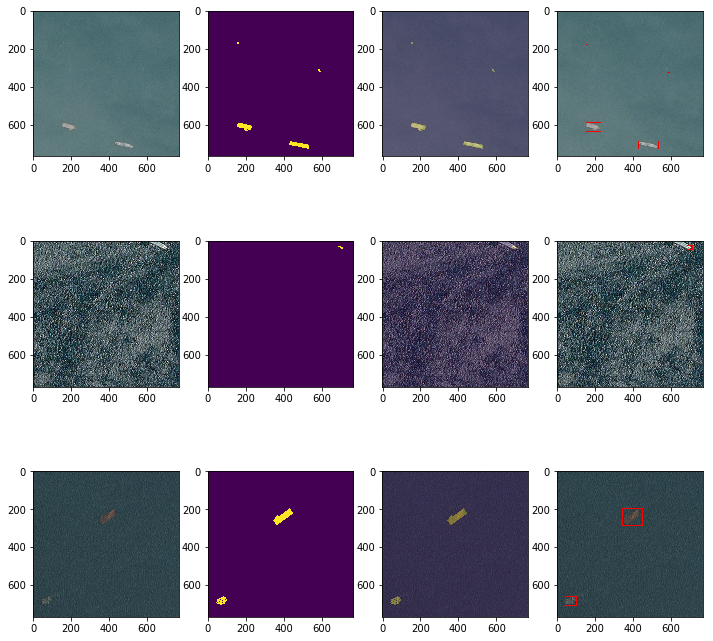

In [19]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
# Decode the EncodedPixels to pixel info
#EncodedPixels are stored as (start, length) pair in a success as string format
def rle_decode(mask_rle, shape=(768, 768)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    #s[::2] means every two elements
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for start, end in zip(starts, ends):
        img[start:end] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction


for _ in range(1):
    fig, axes = plt.subplots(3, 4, figsize=(12, 12))
    train_sample = train[~train.EncodedPixels.isna()].sample(3)

    for i, image_id in enumerate(train_sample.ImageId):
        img = imread(f'../input/train_v2/{image_id}')
        mask_shape = img.shape[:-1]
        mask = np.zeros(mask_shape)

        encoded_pixels_list = train[train.ImageId == image_id].EncodedPixels.tolist()
        for encoded_pixels in encoded_pixels_list:
            mask += rle_decode(encoded_pixels, mask_shape)
        
        #skimage.measure.label: Label connected regions of an integer array.
        #use sample:http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label
        lbl = label(mask) 
        #skimage.measure.regionprops:Measure properties of labeled image regions. input is the labeled image
        props = regionprops(lbl)
        img_1 = img.copy()
        for prop in props:
            #regionprops.bbox : tuple Bounding box (min_row, min_col, max_row, max_col) of the labeled image
            cv2.rectangle(img_1, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 2)

        row = i//1
        col = 0
        axes[row][col].axis('on')
        axes[row][col+1].axis('on')
        axes[row][col+2].axis('on')
        axes[row][col+3].axis('on')
        axes[row][col].imshow(img)
        axes[row][col+1].imshow(mask)
        axes[row][col+2].imshow(img)
        axes[row][col+2].imshow(mask,alpha=0.3)
        axes[row][col+3].imshow(img_1)

    plt.show()

>### Plot images with ships in mask and images with no-ships in mask


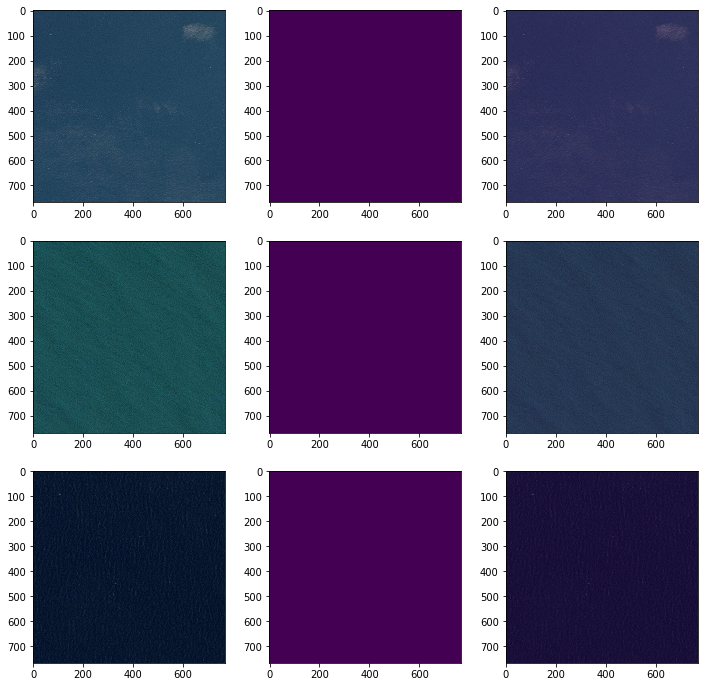

In [21]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
train_sample = train[train.EncodedPixels.isna()].sample(3)

for i, image_id in enumerate(train_sample.ImageId):
    img = imread(f'../input/train_v2/{image_id}')
    mask_shape = img.shape[:-1]
    mask = np.zeros(mask_shape)

    row = i // 1
    col = 0
    axes[row][col].axis('on')
    axes[row][col+1].axis('on')
    axes[row][col+2].axis('on')
    axes[row][col].imshow(img)
    axes[row][col+1].imshow(mask)
    axes[row][col+2].imshow(img)
    axes[row][col+2].imshow(mask,alpha=0.3)
    
plt.show()

>### EncodedPixels size distribution

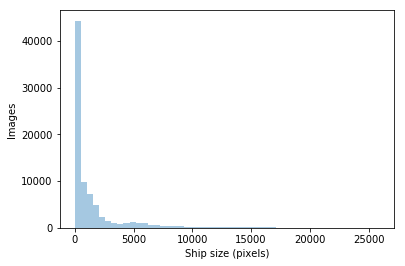

In [22]:
def ship_pixel(encodedpixels):
    if isinstance(encodedpixels, str):
        rle = np.array(list(zip(*[iter(int(x) for x in encodedpixels.split())]*2)))
    else:
        rle = np.array([])
    if rle.size > 0:
        return np.sum(rle[:,1])
    return 0

ship_pixels = train.dropna().EncodedPixels.map(lambda x: ship_pixel(x))

sns.distplot(ship_pixels, kde=False)
plt.xlabel('Ship size (pixels)');
plt.ylabel('Images');


>### Ship numbers distribution after dropping noship images

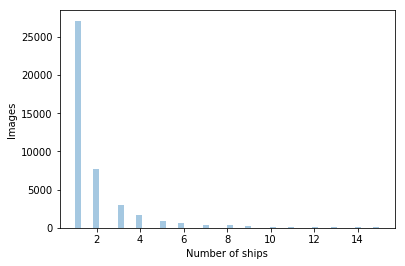

In [26]:
ships_number = train.dropna().groupby('ImageId').count()
ships_number.rename({'EncodedPixels': 'ObjCount'}, axis='columns', inplace=True)
sns.distplot(ships_number.ObjCount, kde=False)
plt.xlabel('Number of ships');
plt.ylabel('Images');